# Corpus Stats & CountVectorizer Settings

In [1]:
%matplotlib inline
from pathlib import Path
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, FloatRangeSlider
from matplotlib.ticker import FuncFormatter, ScalarFormatter
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import LdaModel, LdaMulticore
from gensim.corpora import Dictionary
from gensim.matutils import Sparse2Corpus
from gensim.corpora.dictionary import Dictionary
from pprint import pprint
from scipy import sparse
import pyLDAvis
from pyLDAvis.gensim import prepare
from gensim.models import CoherenceModel

In [2]:
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

In [3]:
percentiles=np.arange(.1, 1, .1).round(1)

## Read Text

In [4]:
text_path = Path('../data/clean_stop')
text_files = text_path.glob('*.txt')
docs = [f.read_text() for f in text_files]
len(docs)

26717

## Get Corpus Stats

### Token count via Counter()

In [5]:
token_count = Counter()
for i, doc in enumerate(docs, 1):
    if i % 5000 == 0:
        print(i, end=' ', flush=True)
    token_count.update(doc.split())

5000 10000 15000 20000 25000 

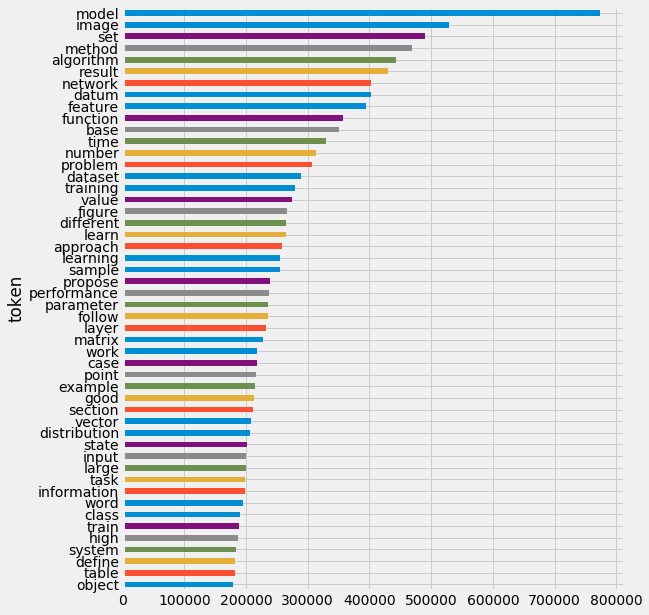

In [6]:
(pd.DataFrame(token_count.most_common(n=50), columns=['token', 'count'])
 .set_index('token')
 .squeeze()
 .sort_values()
 .plot
 .barh(figsize=(8, 10)));

### Document Frequency Distribution

#### Binary DTM

In [8]:
binary_vectorizer = CountVectorizer(max_df=1.0,
                             min_df=1,
                             stop_words='english',
                             max_features=None,
                             binary=True)

binary_dtm = binary_vectorizer.fit_transform(docs)

In [9]:
binary_dtm

<26717x63733 sparse matrix of type '<class 'numpy.int64'>'
	with 18184467 stored elements in Compressed Sparse Row format>

In [10]:
tokens = binary_vectorizer.get_feature_names()

#### Persist result

In [11]:
sparse.save_npz('binary_dtm', binary_dtm)
pd.Series(tokens).to_csv('tokens.csv', index=False)

#### Load result

In [19]:
binary_dtm = sparse.load_npz('binary_dtm.npz')
tokens = pd.read_csv('tokens.csv', header=None, squeeze=True)

In [12]:
doc_freq = pd.Series(np.array(binary_dtm.sum(axis=0)).squeeze()).div(binary_dtm.shape[0])
max_unique_tokens = np.array(binary_dtm.sum(axis=1)).squeeze().max()

In [13]:
n_docs, n_tokens = binary_dtm.shape

In [17]:
df_range = FloatRangeSlider(value=[0.0, 1.0],
                            min=0,
                            max=1,
                            step=0.0001,
                            description='Doc. Freq.',
                            disabled=False,
                            continuous_update=True,
                            orientation='horizontal',
                            readout=True,
                            readout_format='.1%',
                            layout={'width': '800px'})

@interact(df_range=df_range)
def document_frequency_simulator(df_range):
    min_df, max_df = df_range
    keep = doc_freq.between(left=min_df, right=max_df)
    left = keep.sum()

    fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
    updated_dtm = binary_dtm.tocsc()[:, np.flatnonzero(keep)]
    unique_tokens_per_doc = np.array(updated_dtm.sum(axis=1)).squeeze()
    sns.distplot(unique_tokens_per_doc, ax=axes[0], kde=False, norm_hist=False)
    axes[0].set_title('Unique Tokens per Doc')
    axes[0].set_yscale('log')
    axes[0].set_xlabel('# Unique Tokens')
    axes[0].set_ylabel('# Documents (log scale)')
    axes[0].set_xlim(0, max_unique_tokens)    
    axes[0].yaxis.set_major_formatter(ScalarFormatter())

    term_freq = pd.Series(np.array(updated_dtm.sum(axis=0)).squeeze())
    sns.distplot(term_freq, ax=axes[1], kde=False, norm_hist=False)
    axes[1].set_title('Document Frequency')
    axes[1].set_ylabel('# Tokens')
    axes[1].set_xlabel('# Documents')
    axes[1].set_yscale('log')
    axes[1].set_xlim(0, n_docs)
#     axes[1].yaxis.set_major_formatter(ScalarFormatter())

    title = f'Document/Term Frequency Distribution | # Tokens: {left:,d} ({left/n_tokens:.2%})'
    fig.suptitle(title, fontsize=14)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

interactive(children=(FloatRangeSlider(value=(0.0, 1.0), description='Doc. Freq.', layout=Layout(width='800px'…